# Proyecto Individual 2

## EDA
Primero defino los 3 KPIs que voy a buscar

### KPIs:
1. Aumentar la velocidad media de conexión a Internet en las provincias del interior del pais en un 30% en el próximo año. (4T 2022)
2. Aumentar en un 2% el acceso al servicio de internet para el próximo trimestre, cada 100 hogares, por provincia. (3T 2023)
3. Aumentar el uso de tecnología wireless en un 20% en el próximo año. (4T 2022)

Despues empiezo importando las librerias que voy a usar

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## ETL

Cargo todos los archivos que voy a usar y comienzo con las transformaciones

Empezando por Accesos por Velocidad

In [34]:
acc_velocidad = pd.read_csv('data/Accesos por velocidad.csv', thousands=',', decimal='.')
acc_velocidad.columns= acc_velocidad.columns.str.strip()
acc_velocidad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Año                  960 non-null    int64  
 1   Trimestre            960 non-null    int64  
 2   Provincia            960 non-null    object 
 3   HASTA 512 kbps       960 non-null    int64  
 4   + 512 Kbps - 1 Mbps  960 non-null    int64  
 5   + 1 Mbps - 6 Mbps    960 non-null    int64  
 6   + 6 Mbps - 10 Mbps   960 non-null    int64  
 7   + 10 Mbps - 20 Mbps  960 non-null    int64  
 8   + 20 Mbps - 30 Mbps  960 non-null    int64  
 9   + 30 Mbps            960 non-null    int64  
 10  OTROS                954 non-null    float64
 11  Total                960 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 90.1+ KB


Al ver la informacion de Accesos por velocidad noto que hay unos valores faltantes en la columna OTROS  
Como no considero que sean importantes para lo que busco lo lleno con 0

Y ademas saco los valores nulos de la columna Provincia

In [35]:
acc_velocidad[acc_velocidad['OTROS'].isna()]
acc_velocidad['OTROS'].fillna(0,inplace=True)
acc_velocidad.dropna(subset=['Provincia'],inplace=True)

C:\Users\biott\AppData\Local\Temp\ipykernel_9572\2643721610.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  acc_velocidad['OTROS'].fillna(0,inplace=True)


Revisando me di cuenta de que tiene unos valores en la columna Año son 2024 que yo creo son un error y deberian ser 2023 ya que habla del 4to trimestre asi que lo corrijo.

In [36]:
acc_velocidad.head()
acc_velocidad['Año'] = acc_velocidad['Año'].replace(2024, 2023)

Cargo el archivo de Totales Accesos Por Tecnologia y elimino la columna Periodo ya que muestra la misma informacion que Trimestre y Año

In [37]:
tot_acc_tec = pd.read_csv('data/Totales Accesos Por Tecnología.csv', thousands=',', decimal='.')
tot_acc_tec.drop(columns=' Periodo ',inplace=True)
tot_acc_tec.columns= tot_acc_tec.columns.str.strip() # Hago un strip ya que los nombres de las columnas tienen espacios al principio y final

Y por ultimo cargo los ultimos tres archivos en los que solo tengo que hacer un strip en los nombres de las columnas.

In [38]:
tot_acc_vel = pd.read_csv('data/Totales Accesos por velocidad.csv', thousands=',', decimal='.')
tot_acc_vel.columns= tot_acc_vel.columns.str.strip()

vel_prov = pd.read_csv('data/Velocidad % por prov.csv', thousands=',', decimal='.')
vel_prov.columns= vel_prov.columns.str.strip()

penetracion_pob = pd.read_csv('data/Penetración-poblacion.csv', thousands=',', decimal='.')
penetracion_pob.columns= penetracion_pob.columns.str.strip()
penetracion_pob['Provincia'] = penetracion_pob['Provincia'].str.strip() #En esta tambien hago un strip en los nombres de las Provincias ya que hay algunas que parecen duplicadas por algunos espacios al final  y/o al principio

Verifico si hay NA en los DFs

In [39]:
print(acc_velocidad.isna().sum())
print(tot_acc_tec.isna().sum())
print(tot_acc_vel.isna().sum())
print(vel_prov.isna().sum())
print(penetracion_pob.isna().sum())

Año                    0
Trimestre              0
Provincia              0
HASTA 512 kbps         0
+ 512 Kbps - 1 Mbps    0
+ 1 Mbps - 6 Mbps      0
+ 6 Mbps - 10 Mbps     0
+ 10 Mbps - 20 Mbps    0
+ 20 Mbps - 30 Mbps    0
+ 30 Mbps              0
OTROS                  0
Total                  0
dtype: int64
Año             0
Trimestre       0
ADSL            0
Cablemodem      0
Fibra óptica    0
Wireless        0
Otros           0
Total           0
dtype: int64
Año                        0
Trimestre                  0
Hasta 512 kbps             0
Entre 512 Kbps y 1 Mbps    0
Entre 1 Mbps y 6 Mbps      0
Entre 6 Mbps y 10 Mbps     0
Entre 10 Mbps y 20 Mbps    0
Entre 20 Mbps y 30 Mbps    0
Más de 30 Mbps             0
OTROS                      0
Total                      0
dtype: int64
Año                       0
Trimestre                 0
Provincia                 0
Mbps (Media de bajada)    0
dtype: int64
Año                         0
Trimestre                   0
Provincia    

Y ahora busco los outliers y los saco de los DFs

In [40]:
# Tomo solo los valores sin outliers en las diferentes DFs
for col in acc_velocidad.iloc[:,3:].columns:
    Q1 = acc_velocidad[col].quantile(0.25)
    Q3 = acc_velocidad[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    acc_velocidad_NO = acc_velocidad[(acc_velocidad[col] >= lower_bound) & (acc_velocidad[col] <= upper_bound)]

In [41]:
for col in tot_acc_tec.iloc[:,2:].columns:
    Q1 = tot_acc_tec[col].quantile(0.25)
    Q3 = tot_acc_tec[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    tot_acc_tec_NO = tot_acc_tec[(tot_acc_tec[col] >= lower_bound) & (tot_acc_tec[col] <= upper_bound)]

In [42]:
for col in tot_acc_vel.iloc[:,2:].columns:
    Q1 = tot_acc_vel[col].quantile(0.25)
    Q3 = tot_acc_vel[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    tot_acc_vel_NO = tot_acc_vel[(tot_acc_vel[col] >= lower_bound) & (tot_acc_vel[col] <= upper_bound)]

vel_prov_NO = vel_prov.copy() # En este df no saco los outliers ya que estos son solamente los valores de 2023 y me quedan los graficos incompletos

col = 'Accesos por cada 100 hab'
Q1 = penetracion_pob[col].quantile(0.25)
Q3 = penetracion_pob[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
penetracion_pob_NO = penetracion_pob[(penetracion_pob[col] >= lower_bound) & (penetracion_pob[col] <= upper_bound)]

Ahora busco si tienen valores duplicados

In [43]:
dup_acc_velocidad_NO = acc_velocidad_NO[acc_velocidad_NO.duplicated()]
dup_tot_acc_tec_NO = tot_acc_tec_NO[tot_acc_tec_NO.duplicated()]
dup_tot_acc_vel_NO = tot_acc_vel_NO[tot_acc_vel_NO.duplicated()]
dup_vel_prov_NO = vel_prov_NO[vel_prov_NO.duplicated()]
dup_penetracion_pob_NO = penetracion_pob_NO[penetracion_pob_NO.duplicated()]

print(f'Duplicados de acc_velocidad_NO: {len(dup_acc_velocidad_NO)}\nDuplicados de tot_acc_tec_NO: {len(dup_tot_acc_tec_NO)}\nDuplicados de tot_acc_vel_NO: {len(dup_tot_acc_vel_NO)}\nDuplicados de vel_prov_NO: {len(dup_vel_prov_NO)}\nDuplicados de penetracion_pob_NO: {len(dup_penetracion_pob_NO)}')

Duplicados de acc_velocidad_NO: 0
Duplicados de tot_acc_tec_NO: 0
Duplicados de tot_acc_vel_NO: 0
Duplicados de vel_prov_NO: 0
Duplicados de penetracion_pob_NO: 0


## Analisis

Tomo de cada DF solamente los valores que me van a servir para explorar los KPIs

In [44]:
vel_prov_NO_Analisis = vel_prov_NO[(~vel_prov_NO['Provincia'].isin(['Buenos Aires', 'Capital Federal'])) & (vel_prov_NO['Año']<=2022)] #Aca solo tomo los valores que no sean Capital o Buenos Aires ya que busco el interior del pais
penetracion_pob_NO_Analisis = penetracion_pob_NO[penetracion_pob_NO['Año']<=2023]
tot_acc_tec_NO_Analisis = tot_acc_tec_NO[tot_acc_tec_NO['Año']<=2022] # Aca tomo solamente los valores de antes de 2023 para saber como se comporto la tecnologia Wireless en el pasado y asi sacar conclusiones para el futuro

Chequeo cuanto han cambiado en % el promedio de bajada en cada año

In [45]:
avg_mbps_por_anio = vel_prov_NO_Analisis.groupby('Año')['Mbps (Media de bajada)'].mean().reset_index() # Primero agrupo todo por año y saco el promedio

avg_mbps_por_anio.sort_values(by='Año', inplace=True) # Ahora lo ordeno por año

avg_mbps_por_anio['Cambio %'] = avg_mbps_por_anio['Mbps (Media de bajada)'].pct_change() * 100 # Creo una columna en la que cargo el cambio % que hay en cada año

avg_mbps_por_anio['Cambio %'].fillna(0, inplace=True) # Relleno los NA con 0 (El primer año tiene NA ya que no hay un valor anterior a este)

avg_mbps_por_anio # Lo muestro

C:\Users\biott\AppData\Local\Temp\ipykernel_9572\1432089298.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  avg_mbps_por_anio['Cambio %'].fillna(0, inplace=True) # Relleno los NA con 0 (El primer año tiene NA ya que no hay un valor anterior a este)


,Año,Mbps (Media de bajada),Cambio %
0,2014,3.331136,0.000000
1,2015,4.043523,21.385686
2,2016,4.646818,14.920046
3,2017,6.010682,29.350484
4,2018,8.992045,49.601089
5,2019,12.598523,40.107418
6,2020,19.290568,53.117700
7,2021,25.359318,31.459675
8,2022,40.326136,59.019009


En el df que hice podemos ver como se aumenta entre un 15% y un 60% cada año asi que un 30% me parece correcto ademas venimos de un año con demasiada mejora

Empiezo con graficar las velocidades promedio en las provincias durante los años

C:\Users\biott\AppData\Local\Temp\ipykernel_9572\2969010338.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Provincia')


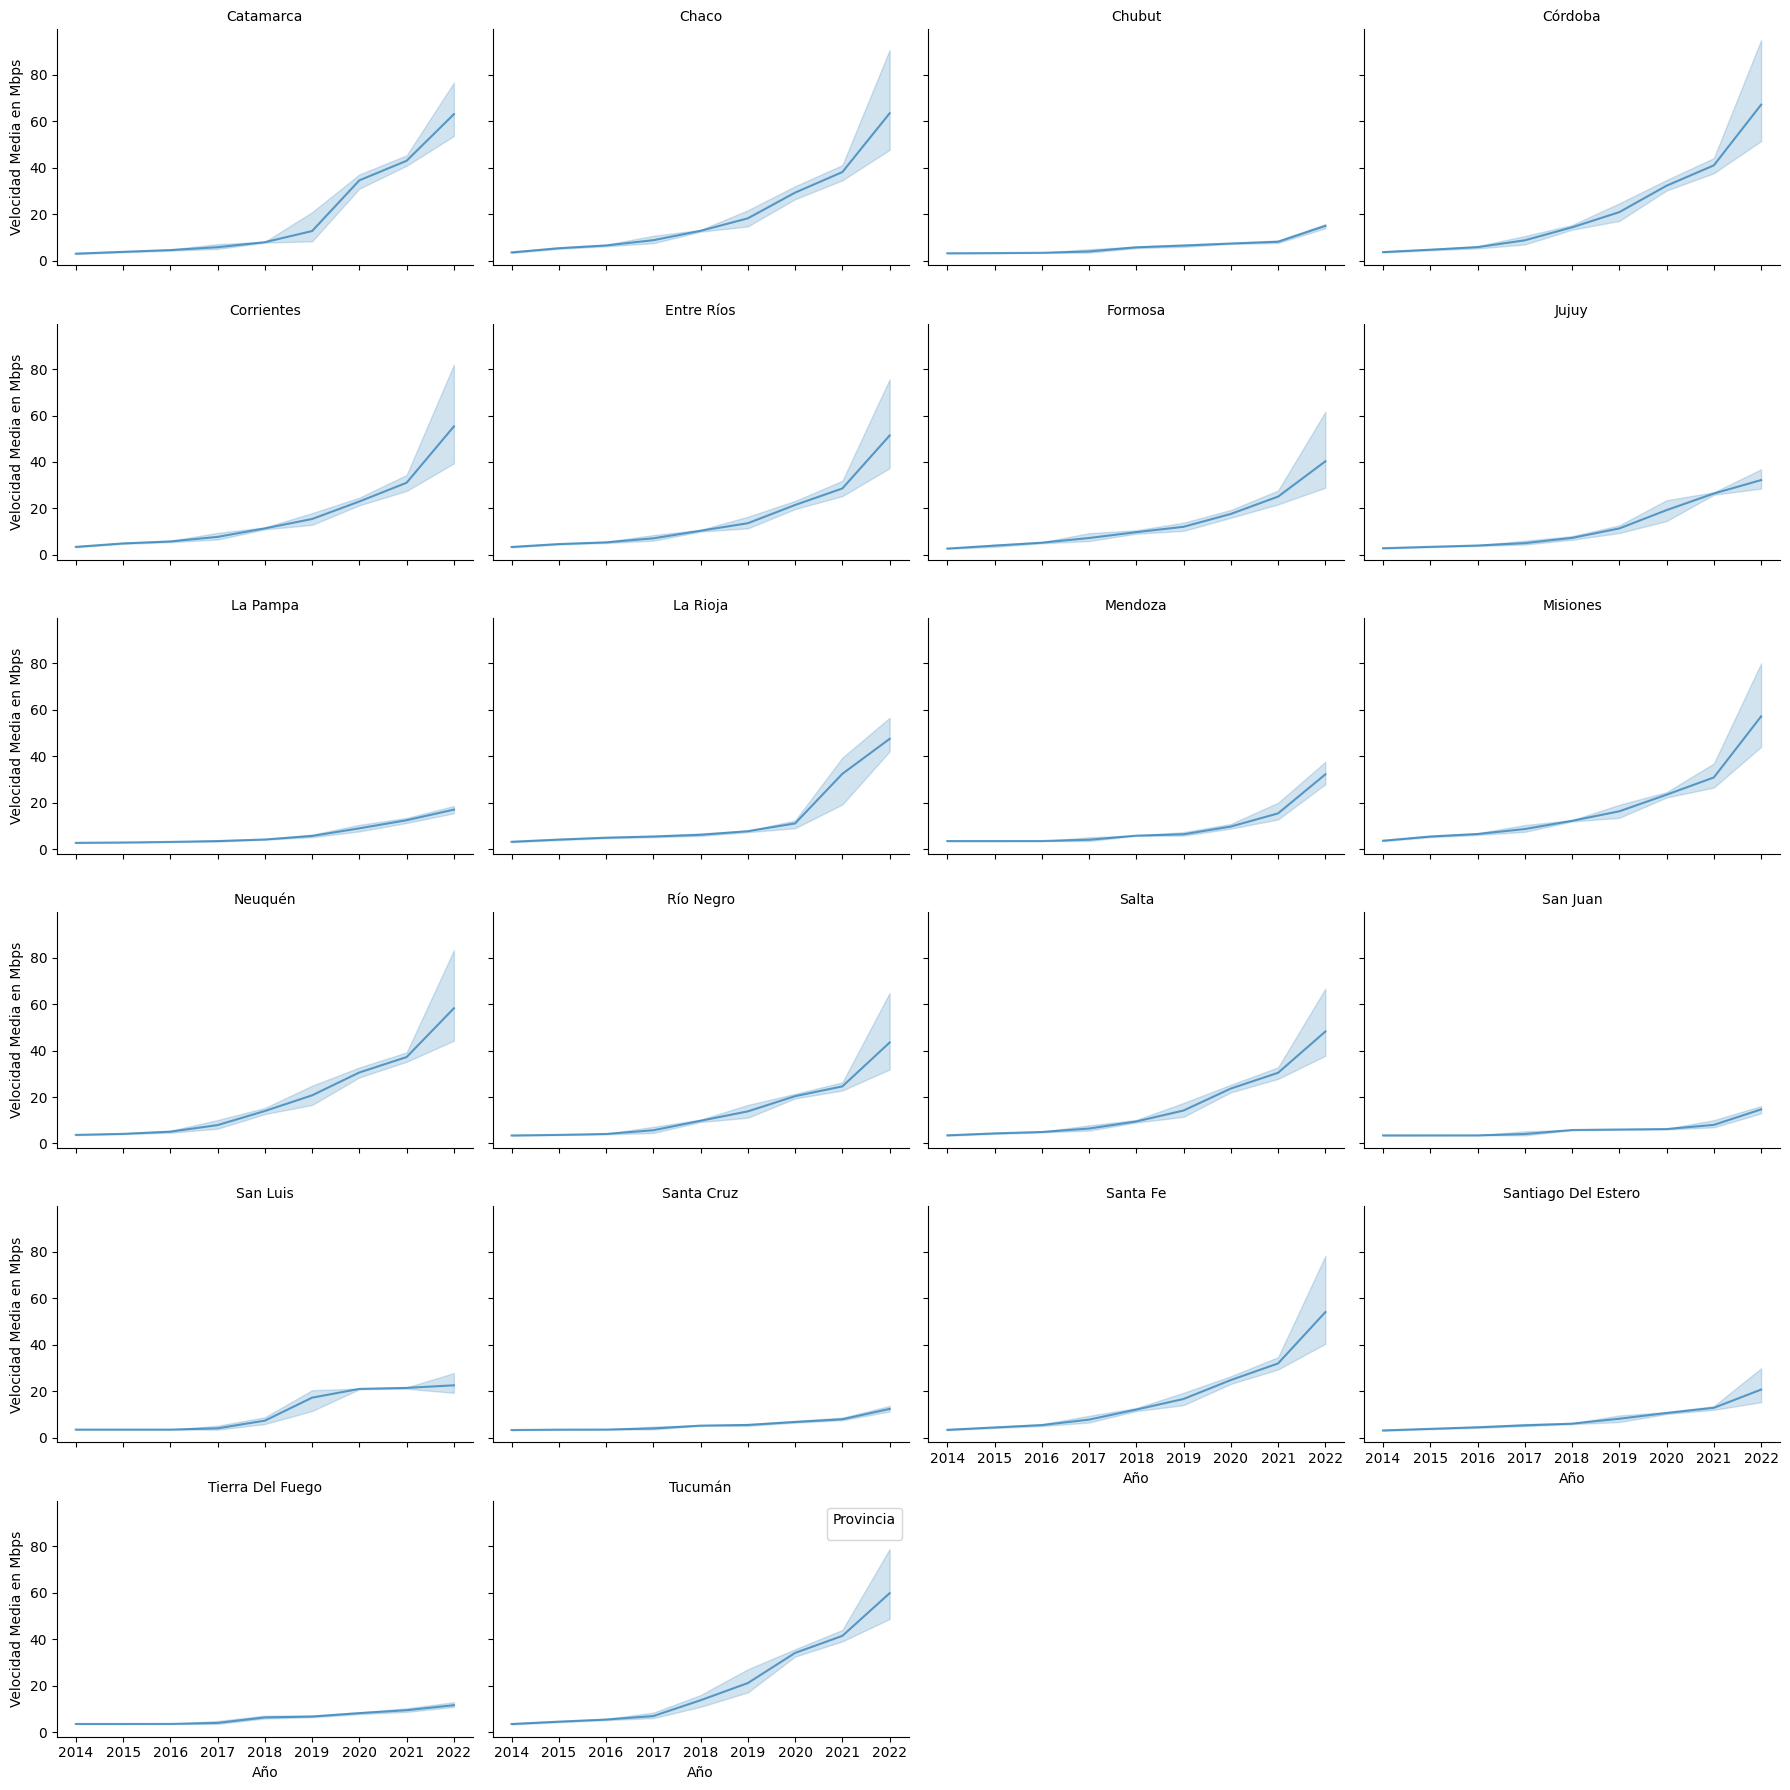

In [46]:
g1 = sns.FacetGrid(vel_prov_NO_Analisis, col='Provincia', col_wrap=4, height=3, aspect=1.5)
g1.map(sns.lineplot, 'Año', 'Mbps (Media de bajada)', alpha=0.7)
g1.set_titles('{col_name}')
g1.set_axis_labels('Año', 'Velocidad Media en Mbps')
plt.subplots_adjust(top=0.9)
plt.legend(title='Provincia')
plt.tight_layout()
plt.show()

Verifico como se comporto el acceso al servicio de Internet en los ultimos años

C:\Users\biott\AppData\Local\Temp\ipykernel_9572\940792040.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Provincia')


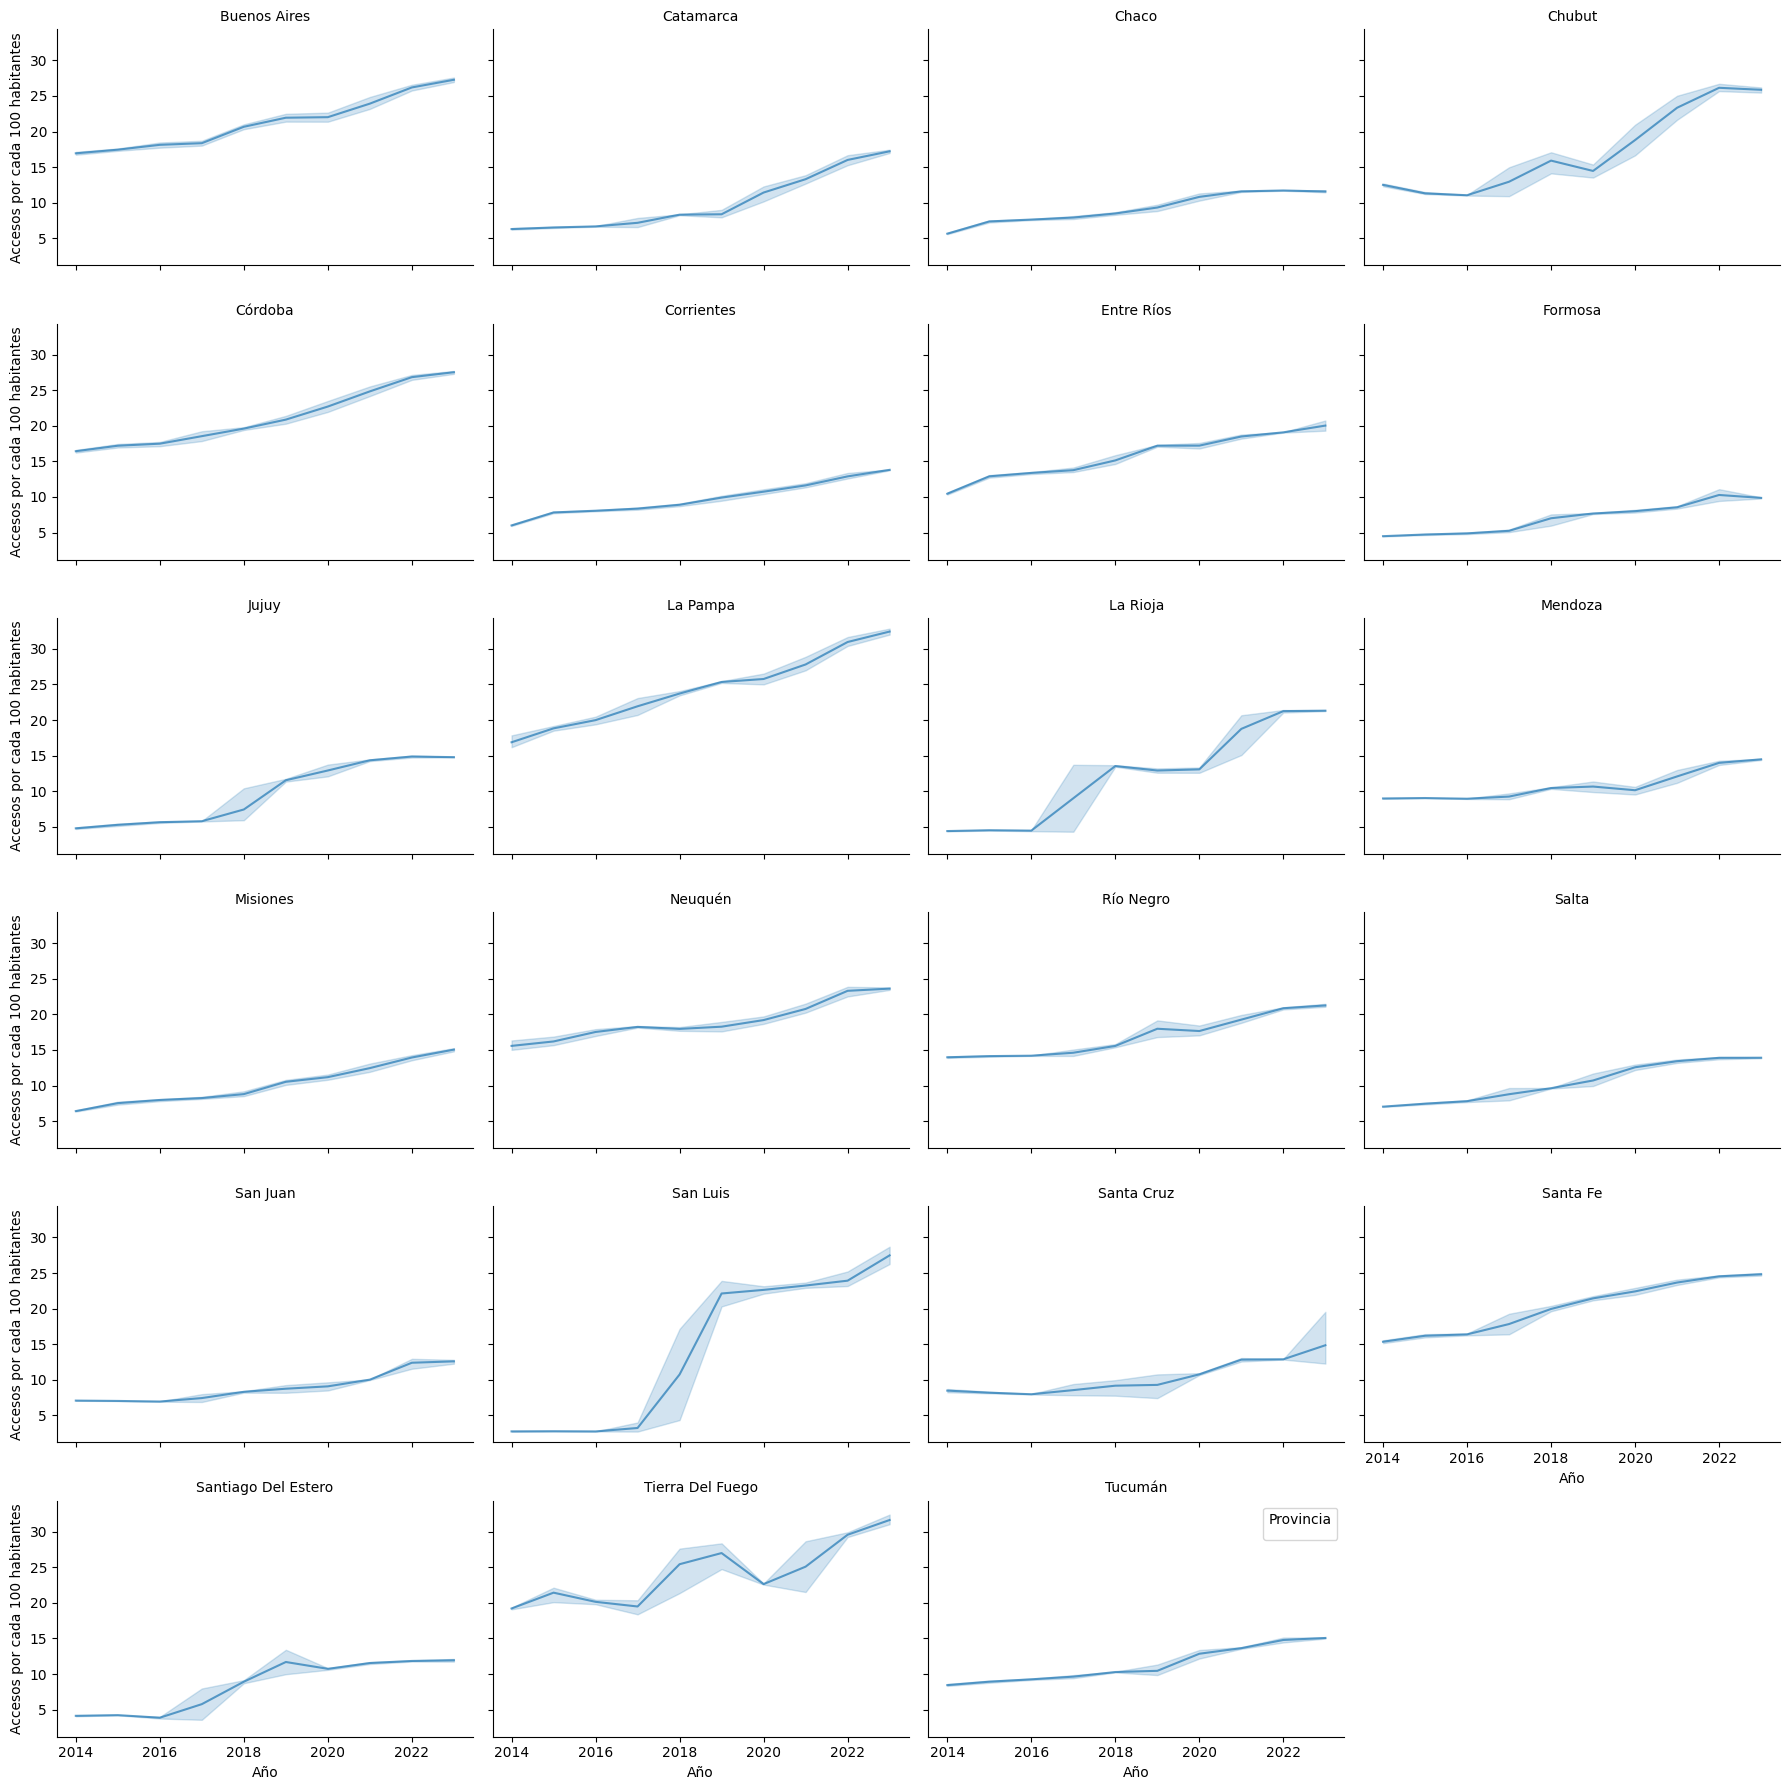

In [47]:
penetracion_pob_NO_Analisis.head()
g = sns.FacetGrid(penetracion_pob_NO_Analisis, col='Provincia', col_wrap=4, height=3, aspect=1.5)
g.map(sns.lineplot, 'Año', 'Accesos por cada 100 hab', alpha=0.7)
g.set_titles('{col_name}')
g.set_axis_labels('Año', 'Accesos por cada 100 habitantes')
plt.subplots_adjust(top=0.9)
plt.legend(title='Provincia')
plt.tight_layout()
plt.show()

Verifico como aumento en el tiempo previo a 2022 la tecnología Wireless

In [48]:
incremento_Wireless_1 = tot_acc_tec_NO_Analisis[(tot_acc_tec_NO_Analisis['Año']==2018) & (tot_acc_tec_NO_Analisis['Trimestre']==1)]['Wireless'].values[0] * 100 / tot_acc_tec_NO_Analisis[(tot_acc_tec_NO_Analisis['Año']==2017) & (tot_acc_tec_NO_Analisis['Trimestre']==1)]['Wireless'].values[0]
incremento_Wireless_2 = tot_acc_tec_NO_Analisis[(tot_acc_tec_NO_Analisis['Año']==2019) & (tot_acc_tec_NO_Analisis['Trimestre']==1)]['Wireless'].values[0] * 100 / tot_acc_tec_NO_Analisis[(tot_acc_tec_NO_Analisis['Año']==2018) & (tot_acc_tec_NO_Analisis['Trimestre']==1)]['Wireless'].values[0]
incremento_Wireless_3 = tot_acc_tec_NO_Analisis[(tot_acc_tec_NO_Analisis['Año']==2020) & (tot_acc_tec_NO_Analisis['Trimestre']==1)]['Wireless'].values[0] * 100 / tot_acc_tec_NO_Analisis[(tot_acc_tec_NO_Analisis['Año']==2019) & (tot_acc_tec_NO_Analisis['Trimestre']==1)]['Wireless'].values[0]
incremento_Wireless_4 = tot_acc_tec_NO_Analisis[(tot_acc_tec_NO_Analisis['Año']==2021) & (tot_acc_tec_NO_Analisis['Trimestre']==1)]['Wireless'].values[0] * 100 / tot_acc_tec_NO_Analisis[(tot_acc_tec_NO_Analisis['Año']==2020) & (tot_acc_tec_NO_Analisis['Trimestre']==1)]['Wireless'].values[0]
incremento_Wireless_5 = tot_acc_tec_NO_Analisis[(tot_acc_tec_NO_Analisis['Año']==2022) & (tot_acc_tec_NO_Analisis['Trimestre']==1)]['Wireless'].values[0] * 100 / tot_acc_tec_NO_Analisis[(tot_acc_tec_NO_Analisis['Año']==2021) & (tot_acc_tec_NO_Analisis['Trimestre']==1)]['Wireless'].values[0]
print(f'La tecnologia Wireless aumento un {incremento_Wireless_1}% entre 2017 y 2018')
print(f'La tecnologia Wireless aumento un {incremento_Wireless_2}% entre 2018 y 2019')
print(f'La tecnologia Wireless aumento un {incremento_Wireless_3}% entre 2019 y 2020')
print(f'La tecnologia Wireless aumento un {incremento_Wireless_4}% entre 2021 y 2020')
print(f'La tecnologia Wireless aumento un {incremento_Wireless_5}% entre 2022 y 2021')

La tecnologia Wireless aumento un 194.8993668423473% entre 2017 y 2018
La tecnologia Wireless aumento un 167.2226255293406% entre 2018 y 2019
La tecnologia Wireless aumento un 127.46337986896704% entre 2019 y 2020
La tecnologia Wireless aumento un 123.33445916221302% entre 2021 y 2020
La tecnologia Wireless aumento un 125.6049964560877% entre 2022 y 2021


Viendo los aumentos que tuvo la tecnologia wireless creo que para finales de 2023 tendria que aumentar un 20% mas

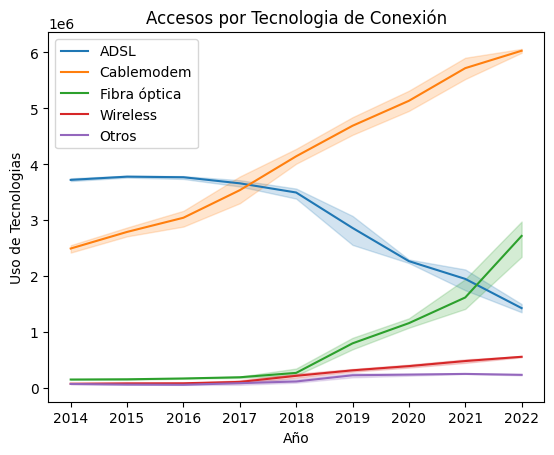

In [49]:
sns.lineplot(data= tot_acc_tec_NO_Analisis, x= 'Año', y= 'ADSL', label='ADSL')
sns.lineplot(data= tot_acc_tec_NO_Analisis, x= 'Año', y= 'Cablemodem', label='Cablemodem')
sns.lineplot(data= tot_acc_tec_NO_Analisis, x= 'Año', y= 'Fibra óptica', label='Fibra óptica')
sns.lineplot(data= tot_acc_tec_NO_Analisis, x= 'Año', y= 'Wireless', label='Wireless')
sns.lineplot(data= tot_acc_tec_NO_Analisis, x= 'Año', y= 'Otros', label='Otros')
plt.title('Accesos por Tecnologia de Conexión')
plt.ylabel('Uso de Tecnologias')
plt.show()

Por ultimo cargo los valores que necesito para chequear los KPIs

In [50]:
kpi_1 = vel_prov_NO[~vel_prov_NO['Provincia'].isin(['Buenos Aires', 'Capital Federal'])]

In [51]:
kpi_2 = penetracion_pob_NO[(penetracion_pob_NO['Año'] >= 2023) & (penetracion_pob_NO['Trimestre'] >= 3)]

In [52]:
kpi_3 = tot_acc_tec_NO[tot_acc_tec_NO['Año']>= 2022].iloc[:5]

Ahora guardo los datos que me van a ayudar a corroborar mis KPIs en archivos

In [53]:
kpi_1.to_csv('data_kpi/kpi_1.csv')
kpi_2.to_csv('data_kpi/kpi_2.csv')
kpi_3.to_csv('data_kpi/kpi_3.csv')

Y guardo tambien los datos sin outliers para usar en mi analisis de Power BI

In [56]:
vel_prov_NO.to_csv('data/vel_prov_NO.csv')
penetracion_pob_NO.to_csv('data/penetracion_pob_NO.csv')
tot_acc_tec_NO.to_csv('data/tot_acc_tec_NO.csv')

Y ahora empiezo a chequear si se cumplieron o no los KPIs planteados usando Power BI